Play with VFTS 682

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/')
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from plot_defaults import *
from clean_data import *
from File_reader import reader
from termcolor import colored
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [2]:
#VFTS 352 data (overcontact binary): Gaia DR2 4657678216202797440	084.61858758672 	0.0278	-69.18864504258 	0.0344	4657678216202797440 	0.0270 	0.0304 	1.816 	0.054 	0.815 	0.071 	 

In [4]:
# Load data Gaia DR2 for VFTS682
# GAIA ID: 4657685637907503744, retrieved using the Vizier interface

mu_ra = 1.8429766110812542  # marsec/yr 
err_mu_ra = 0.06974150031513375  # marsec/yr

mu_dec =  0.7855134899438113  # marsec/yr
err_mu_dec = 0.07997805252521194  # masec/yr

# # Load RV from Bestenlehner et al. 2011 (http://adsabs.harvard.edu/abs/2011A%26A...530L..14B)
# radial velocity is missing in DR2
# # from HeII4686
rv = 315     # km/s
err_rv = 15  # km/s

rv_30Dor = 270  # km/s
err_rv_30Dor = 10  # km/s


# # peculiar RV
drv = rv_30Dor - rv  
err_drv = err_rv+err_rv_30Dor

# # Distance, assumed
D = 50e3  # pc

# parallax -- not used
parallax = -0.02213454741230581
e_parallax = 0.043642011613831244

# position on the sky
RAvfts682   = 84.73136339876477
e_RAvfts682 = 0.036321212008208974
DEvfts682   = -69.07411071794998
e_RAvfts682 = 0.04825647078875183

In [5]:
def convertDpc_to_km(D):
    return D*3.086e13

def convertyr_to_sec(T):
    return T*3.1558149984e7

def convertmarcsec_to_rad(alpha):
    return alpha*math.pi/(648000000.0)

def prop_motion_to_km_s(mu, D):
    # D needs to be in parsec
    # mu in milliarcsec/yr
    return convertDpc_to_km(D)*(mu/convertyr_to_sec(1))*convertmarcsec_to_rad(1)

def remove_systems(array, ind_to_remove):
    ind_to_keep = np.array(1-ind_to_remove,dtype=bool)
    return array[ind_to_keep]

def min_array(array1, array2):
    if len(array1) != len(array2):
        print colored("arrays have different lengths!giving up...","red")
        return np.nan
    else:
        array = np.zeros(len(array1))
        for i in xrange(len(array1)):
            array[i] = min(array1[i], array2[i])
        return array


In [6]:
# for inset plot
def my_mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2


In [14]:
## read data from vizier

# get filename and header
def getFileData(fname):
    src = np.genfromtxt(fname,
                        comments='#', 
                        delimiter='|', filling_values=-99998)
    ff = open(fname,'r')
    for i,line in enumerate(ff):
        if 'DR2Name|' in line:
            # print i
            col = line.split('|')
            break
    ff.close()
    print col
    return src, col

# read file
def getData(fname):
    src, col = getFileData(fname)
    
    # proper motion RA
    pmRA = src[:, col.index('pmRA')]
    i_pmRA = pmRA != -99998
    
    e_pmRA = src[:, col.index('e_pmRA')]
    i_e_pmRA = e_pmRA != 99998 
    
    # proper motion DEC
    pmDE = src[:, col.index('pmDE')]
    i_pmDE = pmDE != -99998
    
    e_pmDE = src[:, col.index('e_pmDE')]
    i_e_pmDE = e_pmDE != 99998 

    # parallax
    par = src[:, col.index('Plx')]
    # i_par = par != -99998
    
    e_par = src[:, col.index('e_Plx')]
    # i_e_par = e_par != -9998
    
    # filter parallaxes to remove foreground
    # To be implemented
   
    # positions
    RA = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('RA_ICRS')]
    e_RA = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('e_RA_ICRS')]/3.6e6  # note that positions are in degree, but errorbars are in milliarcsec, convert all to degrees
    DE = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('DE_ICRS')]
    e_DE = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('e_DE_ICRS')]/3.6e6 
    
    # select data that have "good" (= not nan)  proper motio and corresponding errors only
    # N.B: we don't filter on parallaxes because many LMC stars will not have it!
    pmDE = pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    pmRA = pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmDE = e_pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmRA = e_pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    par = par[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_par = e_par[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]

    
    return pmRA, e_pmRA, pmDE, e_pmDE, RA, e_RA, DE, e_DE, par, e_par


def getAvg(x,y, e_x, e_y):
    # returns the 1/error weighted average
    num_x = np.sum(x/e_x)
    den_x = np.sum(1/e_x)

    num_y = np.sum(y/e_y)
    den_y = np.sum(1/e_y)

    return num_x/den_x, num_y/den_y


# load data
fname_R136='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/25arcsec_R136a_NEW.tsv'
pmRA_R136, e_pmRA_R136, pmDE_R136, e_pmDE_R136, RA_R136, e_RA_R136, DE_R136, e_DE_R136, par_R136, e_par_R136 = getData(fname_R136) #

fname_around='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/10arcmin_aroundVFTS682_NEW.txt'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) #


# # put all together
# pmRA_tot = np.concatenate((pmRA_around, pmRA_R136))
# pmDE_tot = np.concatenate((pmDE_around, pmDE_R136))
# RA_tot = np.concatenate((RA_around, RA_R136))
# DE_tot = np.concatenate((DE_around, DE_R136))

# print averages
print "============"
print "Average region around (10arcmin)"
avg_pmRA_around, avg_pmDE_around = getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around)
print avg_pmRA_around, avg_pmDE_around
print "tangential velocity"
print math.sqrt(avg_pmRA_around**2+avg_pmDE_around**2)
print len(pmRA_around)
print "============"
print "Average R136"
avg_pmRA_R136, avg_pmDE_R136 = getAvg(pmRA_R136,pmDE_R136, e_pmRA_R136, e_pmDE_R136)
print avg_pmRA_R136, avg_pmDE_R136
print "tangential velocity"
print math.sqrt(avg_pmRA_R136**2+avg_pmDE_R136**2)
print "Relative tangential velocity VFTS862-R136"
print math.sqrt((mu_ra-avg_pmRA_R136)**2+(mu_dec-avg_pmDE_R136)**2)
print mu_ra-avg_pmRA_R136, mu_dec-avg_pmDE_R136
print "============"




['DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'Nper', 'Gmag', 'e_Gmag', 'RPmag', 'RV', 'e_RV\n']
['DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'Nper', 'Gmag', 'e_Gmag', 'RPmag', 'RV', 'e_RV\n']
Average region around (10arcmin)
1.9175838871524207 1.467921643477641
tangential velocity
2.4149372488
1323
Average R136
1.7973845369549635 0.5380899608967432
tangential velocity
1.87620147631
Relative tangential velocity VFTS862-R136
0.251589029867
0.04559207412629074 0.2474235290470681


In [18]:
def get_parametric_eq_line(X0,Y0,slope,x):
    x = np.array(x,dtype=float)
    y = Y0+slope*(x-X0)
    return y

def get_parametric_eq_line2points(X0,Y0, X1, Y1,x):
    x = np.array(x,dtype=float)
    y = Y0+(x-X0)*(X1-X0)/(Y1-Y0)
    return y
    
def plotVFTS682(ax):
    X0 = RAvfts682
    Y0 = DEvfts682

    ax.quiver(X0, Y0, mu_ra, mu_dec, color='r', label='VFTS682', scale=1, units='xy')
    # ax.annotate("shit", xy=(X0,Y0), xytext=(X0+mu_ra,Y0+mu_dec), arrowprops=dict(facecolor='black', shrink=0.05))
    ax.scatter(X0, Y0, color='r', marker='x',lw=3, s=100, zorder=10)
    
    # make error cone
    ax.quiver(RAvfts682,DEvfts682,mu_ra-err_mu_ra,mu_dec+err_mu_dec, color="m", scale=1, units='xy')
    ax.quiver(RAvfts682,DEvfts682,mu_ra+err_mu_ra,mu_dec-err_mu_dec, color="g", scale=1, units='xy')

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax,20)

    edge1 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x), color='m')
    edge2 = ax.plot(x,get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x), color='g')
    # ax.fill_between(x,
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra-err_mu_ra, Y0+mu_dec+err_mu_dec, x),
    #                 get_parametric_eq_line2points(X0,Y0, X0+mu_ra+err_mu_ra, Y0+mu_dec-err_mu_dec, x),
    #                 lw=2, color='#808080', alpha=0.2)

    
    
def mkPlot(ax, pmDE, pmRA, DE, RA, color='b', plotpm=True, zorder=0):
    # notation
    x = pmRA
    y = pmDE
    xx = RA
    yy = DE
       
    #where the stars are
    ax.scatter(xx,yy,alpha=0.5, color=color, zorder=zorder)

    # # their proper motion
    if plotpm == True:
        ax.quiver(xx,yy,x,y, zorder=zorder+1, scale=1, units='xy')
    
    # beautification
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # ax.yaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # ax.xaxis.set_major_locator(MultipleLocator(0.2))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


    ax.set_ylabel(r'$\mathrm{DEC}\ \mathrm{[degrees]}$ ',fontsize=30)
    ax.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)
    
    ax.tick_params(axis='both', which='major', width=2,
                   length=12, pad=10)
    ax.tick_params(axis='both', which='minor', width=2,
                   length=6, pad=10)
    


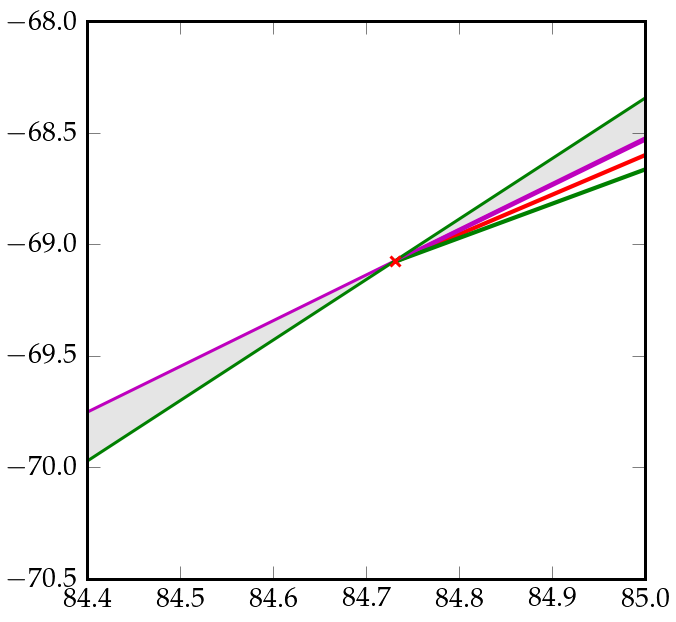

In [60]:
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
ax.set_xlim(84.4,85)
# ax.set_ylim(-69.06-0.02,-69.06-0.01)
#mkPlot(ax, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=True)
# mkPlot(ax, pmDE_around[::200], pmRA_around[::200], DE_around[::200], RA_around[::200], color='b', plotpm=True)
plotVFTS682(ax)

plt.show()

In [16]:
## relative velocity to R136
avg_pmRA_R136, avg_pmDE_R136 = getAvg(pmRA_R136,pmDE_R136, e_pmRA_R136, e_pmDE_R136)
print avg_pmRA_R136, avg_pmDE_R136
print prop_motion_to_km_s(avg_pmRA_R136,D)
print prop_motion_to_km_s(avg_pmDE_R136,D)

rel_RA_R136 = mu_ra - avg_pmRA_R136
rel_DE_R136 = mu_dec - avg_pmDE_R136

print "================="
print "Relative transversal velocity to R136"
print " VFTS682 - R136"
# print rel_RA_R136, rel_DE_R136
pm_rel_R136 = math.sqrt(rel_RA_R136**2+rel_DE_R136**2)
print "|Dv_t|=",pm_rel_R136,"masec/yr"
print "|Dv_r|=",drv, "km/s"
v_rel_RA_R136 = prop_motion_to_km_s(rel_RA_R136, D)
v_rel_DE_R136 = prop_motion_to_km_s(rel_DE_R136, D)
print "|v_pec|=",math.sqrt(drv**2+v_rel_RA_R136**2+v_rel_DE_R136**2)
print "================="

## relative velocity to the region
avg_pmRA_around, avg_pmDE_around = getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around)

rel_RA_around = mu_ra - avg_pmRA_around
rel_DE_around = mu_dec - avg_pmDE_around


print "================="
print "Relative transversal velocity to around"
print " VFTS682 - around"
# print rel_RA_around, rel_DE_around
pm_rel_around = math.sqrt(rel_RA_around**2+rel_DE_around**2)
print "|Dv_t|=",pm_rel_around,"masec/yr"
print "|Dv_r|=",drv, "km/s"
v_rel_RA_around = prop_motion_to_km_s(rel_RA_around, D)
v_rel_DE_around = prop_motion_to_km_s(rel_DE_around, D)
print "|v_pec|=",math.sqrt(drv**2+v_rel_RA_around**2+v_rel_DE_around**2)
print "================="



1.7973845369549635 0.5380899608967432
426.05950465025614
127.5510818543815
Relative transversal velocity to R136
 VFTS682 - R136
|Dv_t|= 0.251589029867 masec/yr
|Dv_r|= -45 km/s
|v_pec|= 74.7104840832
Relative transversal velocity to around
 VFTS682 - around
|Dv_t|= 0.68647442316 masec/yr
|Dv_r|= -45 km/s
|v_pec|= 168.832298013


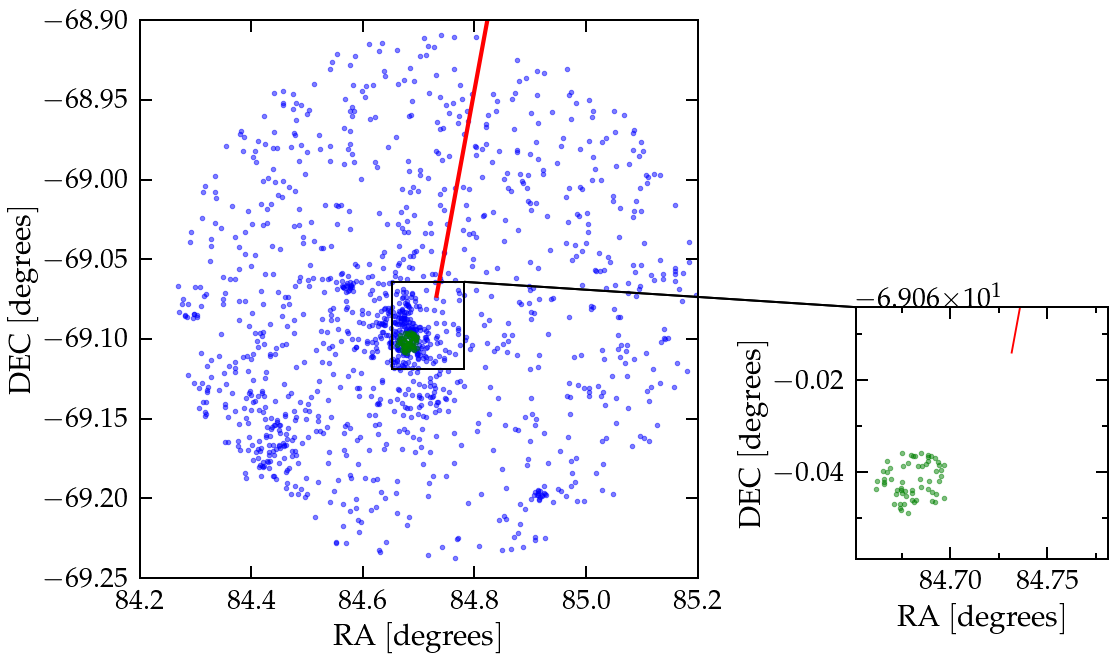

In [19]:
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])

zx = inset_axes(ax, 3.5, 3.5, bbox_to_anchor=(1.75,0.5), bbox_transform=ax.transAxes) 

mkPlot(ax, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=False,zorder=10)
mkPlot(zx, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g', plotpm=False,zorder=10 )
mkPlot(ax, pmDE_around, pmRA_around, DE_around, RA_around, color='b', plotpm=False, zorder=1)
zplot = zx.quiver(RAvfts682,DEvfts682,rel_RA_R136, rel_DE_R136, color='r', label='VFTS682', scale=1, units='xy')
ax.quiver(RAvfts682,DEvfts682,rel_RA_R136, rel_DE_R136, color='r', label='VFTS682', scale=0.2, units='xy')
# plotVFTS682(ax)

zx.spines['left'].set_linewidth(2)
zx.spines['top'].set_linewidth(2)
zx.spines['bottom'].set_linewidth(2)
zx.spines['right'].set_linewidth(2)

zx.yaxis.set_major_locator(MultipleLocator(0.02))
zx.yaxis.set_minor_locator(MultipleLocator(0.01))
zx.xaxis.set_major_locator(MultipleLocator(0.05))
zx.xaxis.set_minor_locator(MultipleLocator(0.025))


zx.set_ylabel(r'$\mathrm{DEC}\ \mathrm{[degrees]}$ ',fontsize=30)
zx.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)

zx.tick_params(axis='both', which='major', width=2,
               length=12, pad=10)
zx.tick_params(axis='both', which='minor', width=2,
               length=6, pad=10)

x,y = getAvg(RA_R136, DE_R136, e_RA_R136, e_DE_R136)

ax.scatter(x,y,color='g', s=100, marker='x', lw=3)


zx.set_xlim(min(RA_R136)-0.01, RAvfts682+0.05)
zx.set_ylim(min(DE_R136)-0.01, DEvfts682+0.01)
ax.set_xlim(84.2,85.2)
ax.set_ylim(-69.25,-68.9)
#ax.arrow(x,y,(RAvfts682-x),(DEvfts682-y),color='b')
my_mark_inset(ax, zx, loc1a=2, loc2a=2, loc1b=1, loc2b=1, fc="none",lw=2, ec="k",zorder=11)

#plt.tight_layout()
fig.savefig('/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/figures/main_plot.pdf', bbox_extra_artists=(zplot,), bbox_inches='tight')


In [46]:
# kinematic age

# get position of the center of R136
x,y = getAvg(RA_R136, DE_R136, e_RA_R136, e_DE_R136)

# per components
dx = RAvfts682 - x # deg
dy = DEvfts682 - y # deg #<- needs to be converted to milliarcsec with factor 3.6e6
time_x = dx*3.6e6/rel_RA_R136 # yr
time_y = dy*3.6e6/rel_DE_R136 #yr
print time_x*1e-6, time_y*1e-6 #Myr

# using projection on the sky
dl = math.sqrt(dx*dx+dy*dy)
dl_dt = math.sqrt(rel_RA_R136*rel_RA_R136+rel_DE_R136*rel_DE_R136) # deg
time_l = dl*3.6e6/dl_dt #yr
print time_l*1e-6 #Myr

# using physical units
dL = dl*D #pc
#dL *= 3.086e13 #km
dv = math.sqrt(prop_motion_to_km_s(rel_RA_R136,D)**2+prop_motion_to_km_s(rel_DE_R136,D)**2) #km/s == pc/Myr
# secyer = 3.1558149984e7 #1year = secyer*seconds
# dv = dv/secyer #km/yr

time_L = dL/dv #yr
print time_L #Myr

# # time
# dt = proj_angular_dist/pm_rel_R136 # year, since pm_rel_R136 is in milliarcsec/yr
# dt *= 1e-6

# dt = (proj_angular_dist*D*3.086e13)/(prop_motion_to_km_s(pm_rel_R136,D))
# 
# dt = dt/secyer


# ax.text(0.5,0.5,r"Flight time $\lesssim$ %0.1f"%float(dt)+r"\,Myr", fontsize=30, transform=ax.transAxes, va="center", ha="center")



3.1855073142140333 0.7394420411562455
1.39747433937
81.8808021517
